<a href="https://colab.research.google.com/github/BhavyaBansal49/Pitchfork/blob/main/Pitchfork_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Pitchfork Data

## Setting up the environment

In [85]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
# Reading sqlite database

from sqlalchemy import create_engine
my_conn= create_engine('sqlite:////content/drive/MyDrive/Project/Kaggle Pitchfork/database.sqlite')

In [88]:
# Check table names
r_set= my_conn.execute('''SELECT name FROM sqlite_master
  where type = 'table' ''')

for row in r_set:
  print(row)

('reviews',)
('artists',)
('genres',)
('labels',)
('years',)
('content',)


In [89]:
# Reading all tables
# Creating dataframes for each table
review_df = pd.read_sql_query("SELECT * from reviews", my_conn)
artist_df = pd.read_sql_query("SELECT * from artists", my_conn) 
genres_df = pd.read_sql_query("SELECT * from genres", my_conn)
labels_df = pd.read_sql_query("SELECT * from labels", my_conn)
years_df = pd.read_sql_query("SELECT * from years", my_conn)
content_df = pd.read_sql_query("SELECT * from content", my_conn)

## SQL

Merge the database tables into a dataframe containing all of the relevant metadata.

In [90]:
# there are duplicate review IDS in all of the tables
# as the first step, we will be deleting all the duplicates
# the one that occurs first will be kept in the database

# removing duplicates
review= review_df.drop_duplicates(subset=['reviewid']).reset_index(drop= True)
artist= artist_df.drop_duplicates(subset=['reviewid']).reset_index(drop= True)
genre= genres_df.drop_duplicates(subset=['reviewid']).reset_index(drop= True)
label= labels_df.drop_duplicates(subset=['reviewid']).reset_index(drop= True)
year= years_df.drop_duplicates(subset=['reviewid']).reset_index(drop= True)
content= content_df.drop_duplicates(subset=['reviewid']).reset_index(drop= True)

In [91]:
# Will use a left join
df = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(review, genre, on= ['reviewid'], how= 'left'), 
              artist, on= ['reviewid'], how= 'left'),
              label, on= ['reviewid'], how= 'left'),
              year, on= ['reviewid'], how= 'left'),
              content, on= ['reviewid'], how= 'left')

# Checking the info for the df
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18389 entries, 0 to 18388
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewid        18389 non-null  int64  
 1   title           18389 non-null  object 
 2   artist_x        18389 non-null  object 
 3   url             18389 non-null  object 
 4   score           18389 non-null  float64
 5   best_new_music  18389 non-null  int64  
 6   author          18389 non-null  object 
 7   author_type     14485 non-null  object 
 8   pub_date        18389 non-null  object 
 9   pub_weekday     18389 non-null  int64  
 10  pub_day         18389 non-null  int64  
 11  pub_month       18389 non-null  int64  
 12  pub_year        18389 non-null  int64  
 13  genre           16024 non-null  object 
 14  artist_y        18389 non-null  object 
 15  label           18351 non-null  object 
 16  year            17983 non-null  float64
 17  content         18389 non-null 

This df is our metadata, based on which we will be doing the further exercises

## Cursory Data Analysis

##### a) Compute the number of albums belonging to each genre. You should notice that some albums have multiple genres listed (e.g. Folk/Country,Pop/R&B,Rock) separated by commas. Consider albums with multiple genres as belonging to each of those genres (i.e. an album with Rap,Rock as it’s genres will be counted as one Rap album and one Rock album).

In [92]:
# split the values
new= genre['genre'].str.split('/')

# make it a series
new_series= new.apply(pd.Series, 1)

# stack the values
new_series_clean= new_series.stack()

# get rid of stack
# drop the level to line up with dataframe
new_series_clean.index= new_series_clean.index.droplevel(-1)

# make the series a dataframe
newdf= pd.DataFrame(new_series_clean)

# delete the genre column
del genre['genre']

# join the genre to newdf
genre= genre.join(newdf)

In [93]:
# reset index
genre[0].value_counts()

rock            9435
electronic      1994
rap             1488
r&b             1087
pop             1087
country          574
folk             574
experimental     565
metal            357
jazz             341
global           183
Name: 0, dtype: int64

##### b) Compute the number of albums released each year.

In [94]:
# subset the two columns, and remove duplicates
temp= df[['title', 'year']]
temp= temp.drop_duplicates().reset_index(drop= True)

# calculate value counts on year
temp['year'].value_counts()

2007.0    1198
2005.0    1158
2012.0    1145
2013.0    1144
2006.0    1134
2008.0    1130
2010.0    1129
2016.0    1124
2011.0    1122
2009.0    1108
2015.0    1101
2014.0    1058
2004.0     983
2003.0     979
2002.0     921
2001.0     556
2000.0     214
1999.0     116
1996.0      33
1971.0      27
1994.0      25
1980.0      25
1979.0      24
1977.0      24
1981.0      24
1992.0      23
1998.0      22
1997.0      21
1990.0      21
1993.0      19
1970.0      18
1985.0      18
1995.0      17
1991.0      17
1968.0      16
1982.0      16
1983.0      15
1972.0      15
1969.0      14
1988.0      14
1989.0      13
1975.0      13
1973.0      13
1978.0      11
1987.0      11
1974.0      11
1984.0      10
1966.0       8
1976.0       8
1967.0       7
1965.0       7
1986.0       6
1964.0       5
1963.0       3
1962.0       3
1960.0       3
1959.0       1
2017.0       1
Name: year, dtype: int64

##### c) Compute the ten artists with the highest number of albums reviewed in the dataset.

In [95]:
# subset the two columns
temp= df[['artist_x', 'reviewid']]
temp= temp.drop_duplicates().reset_index(drop= True)

# create a new dataframe with value counts
count= pd.DataFrame(temp['artist_x'].value_counts())

# sort based on value count column
count.sort_values(by='artist_x', ascending= False, inplace= True)

# display top 10 artists and their value counts
count.head(10)

,artist_x
various artists,687
guided by voices,23
david bowie,21
the beatles,21
of montreal,20
mogwai,20
robert pollard,19
neil young,19
the fall,18
xiu xiu,17


##### d) Compute the mean, median, mode, standard deviation, minimum, and maximum album scores.

In [96]:
print(df['score'].describe())

count    18389.000000
mean         7.005715
std          1.293758
min          0.000000
25%          6.400000
50%          7.200000
75%          7.800000
max         10.000000
Name: score, dtype: float64


##### e) Compute the average score by each review author and return the result in a dataframe sort in descending order.

In [97]:
# create temp using groupby on the metadata
temp= df.groupby('author')['score'].mean().reset_index()

# sort based on score
temp.sort_values(by=['score'], ascending= False, na_position= 'last', inplace= True)

# display top 5
temp.head()

,author,score
310,nelson george,10.000000
278,maura johnston,10.000000
71,carvell wallace,9.833333
124,dorian lynskey,9.500000
356,rollie pemberton & nick sylvester,9.400000


##### f) Compute the average album score per artist and return the result in a dataframe with an additional column for the number of albums they have had reviewed.

In [98]:
# create a temp dataframe based on the requirements
# create a df of artists and albums and drop duplicates
temp1= df[['artist_x', 'title']]
temp1= temp1.drop_duplicates().reset_index(drop= True)

# create a new dataframe with count of unique albums reviewed for every artist
count= pd.DataFrame(temp1['artist_x'].value_counts())
count.reset_index(inplace= True)
count= count.rename({'index': 'artist', 'artist_x': 'count'}, axis= 1)

# calculate average album score per artist
temp2= df.groupby('artist_x')['score'].mean().reset_index()
temp2= temp2.rename({'artist_x': 'artist', 'score': 'score'}, axis= 1)

# merge the two datasets
merge= pd.merge(count, temp2, on= ['artist'], how= 'left')

# show merge
merge

,artist,count,score
0,various artists,687,7.278603
1,guided by voices,23,7.230435
2,david bowie,21,7.742857
3,the beatles,21,8.890476
4,mogwai,20,7.250000
...,...,...,...
8710,yung joc,1,3.200000
8711,fin fang foom,1,5.500000
8712,luke roberts,1,7.500000
8713,alice gerrard,1,7.400000


###### i) Return the artists with the Top 10 highest average scores

In [99]:
# sort based on average score column
merge.sort_values(by=['score'], ascending= False, inplace= True)

# print top 10
merge.head(10)

,artist,count,score
4813,stevie wonder,1,10.00
5120,television,1,10.00
7276,slint,1,10.00
3709,dangelo,1,10.00
5721,talk talk,1,10.00
4833,the stone roses,1,10.00
2663,elvis costello & the attractions,2,9.75
8048,n.w.a.,1,9.70
5404,ultramagnetic mc's,1,9.70
3308,my bloody valentine,2,9.55


###### ii) Return the artists with the Top 10 lowest average scores.

In [100]:
merge.tail(10)

,artist,count,score
7124,"lou reed, metallica",1,1.0
3130,non,2,1.0
4249,geoff farina,1,1.0
6084,"avey tare, kra brekkan",1,1.0
7348,toe,1,0.8
6743,liars academy,1,0.6
8407,shat,1,0.2
8548,dan le sac vs. scroobius pip,1,0.2
6316,push kings,1,0.1
4595,travis morrison,1,0.0


## Dataframe Manipulation

##### a) Create a new DataFrame excluding all artists with names that start with the letter "M" (either upper or lowercase)

In [101]:
# save the df into a temp dataframe
temp= df

# exclude rows starting with m
temp_m= temp[~temp['artist_x'].astype(str).str.startswith('M')]
temp_m= temp_m[~temp['artist_x'].astype(str).str.startswith('m')]

##### b) Create a new DataFrame excluding albums with a score less than 4.0

In [102]:
# create a new df with the required condition
temp_4= temp.loc[temp['score']> 4.0]

# check the minimum
temp_4['score'].min()

4.1

##### c) Create a new DataFrame excluding albums from the label Columbia

In [103]:
# create a new dataframe with the required conditions
temp_c= temp.loc[temp['label']!= 'Columbia']

##### d) Create a new DataFrame excluding albums that belong to metal genre

In [104]:
# create a new dataframe based on required condition
temp_metal= temp[~temp['genre'].astype(str).str.contains('Metal')]
temp_metal= temp_m[~temp['genre'].astype(str).str.contains('metal')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


##### e) create a new DataFrame excluding albums where the artist's name contains an even number of characters (including white space as characters)

In [105]:
# create a dataframe based on the required conditions
temp_even= temp.loc[temp['artist_x'].str.len() % 2== 0]

#check the number of characters in the artist column
temp_even['artist_x'].str.len().head()

0    14
1     8
2    12
3    16
4     4
Name: artist_x, dtype: int64

##### f) Combine these DataFrames into one where each album meets the conditions required for each

In [106]:
# to achieve this, we will just use the temp df originally created
# and apply all filters on the same temp dataframe

# save the df into a temp dataframe
temp= df

# exclude rows starting with m
temp= temp[~temp['artist_x'].astype(str).str.startswith('M')]
temp= temp[~temp['artist_x'].astype(str).str.startswith('m')]

# create a new df with the required condition
temp= temp.loc[temp['score']> 4.0]

# create a new dataframe with the required conditions
temp= temp.loc[temp['label']!= 'Columbia']

# create a new dataframe based on required condition
temp= temp[~temp['genre'].astype(str).str.contains('Metal')]
temp= temp[~temp['genre'].astype(str).str.contains('metal')]

# create a dataframe based on the required conditions
temp= temp.loc[temp['artist_x'].str.len() % 2== 0]

# allocate it to a new dataframe final
final= temp
final.reset_index(inplace= True)

# check final
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7520 entries, 0 to 7519
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           7520 non-null   int64  
 1   reviewid        7520 non-null   int64  
 2   title           7520 non-null   object 
 3   artist_x        7520 non-null   object 
 4   url             7520 non-null   object 
 5   score           7520 non-null   float64
 6   best_new_music  7520 non-null   int64  
 7   author          7520 non-null   object 
 8   author_type     5970 non-null   object 
 9   pub_date        7520 non-null   object 
 10  pub_weekday     7520 non-null   int64  
 11  pub_day         7520 non-null   int64  
 12  pub_month       7520 non-null   int64  
 13  pub_year        7520 non-null   int64  
 14  genre           6821 non-null   object 
 15  artist_y        7520 non-null   object 
 16  label           7504 non-null   object 
 17  year            7338 non-null   f

## Feature Engineering

##### a) Construct a pandas DataFrame containing all album reviews and mettadata. Remove any rows that have null values in any column.

In [107]:
# for this we have to use the original df dataframe
df1= df.dropna()

# we originally had 18389 entries
# check how many entries we have now
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12350 entries, 0 to 18382
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewid        12350 non-null  int64  
 1   title           12350 non-null  object 
 2   artist_x        12350 non-null  object 
 3   url             12350 non-null  object 
 4   score           12350 non-null  float64
 5   best_new_music  12350 non-null  int64  
 6   author          12350 non-null  object 
 7   author_type     12350 non-null  object 
 8   pub_date        12350 non-null  object 
 9   pub_weekday     12350 non-null  int64  
 10  pub_day         12350 non-null  int64  
 11  pub_month       12350 non-null  int64  
 12  pub_year        12350 non-null  int64  
 13  genre           12350 non-null  object 
 14  artist_y        12350 non-null  object 
 15  label           12350 non-null  object 
 16  year            12350 non-null  float64
 17  content         12350 non-null 

##### b) Add a column to the dataframe for each genre. The entry in this column should be a 1 if the album/row in question belons to that genre and 0 otherwise. Remeber that albums can belong to multiple genres.

In [108]:
# separate all genres into one list, considering '// as a separator
genre= df1['genre'].str.split('/').tolist()

# flatten the list
flat_genre= [item for sublist in genre for item in sublist]

# convert to a set to make unique
set_genre= set(flat_genre)

# back to a list
unique_genre= list(set_genre)

# create columns for each unique genre
df1= df1.reindex(df1.columns.tolist() + unique_genre, axis= 1, fill_value= 0)

# for each value inside the column, update the dummy
for index, row in df1.iterrows():
  for val in row.genre.split('/'):
    if val!= 'NA':
      df1.loc[index, val]= 1

# check the df
df1.head()

,reviewid,title,artist_x,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,genre,artist_y,label,year,content,global,experimental,electronic,pop,rap,jazz,r&b,country,metal,rock,folk
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,electronic,massive attack,virgin,1998.0,"“Trip-hop” eventually became a ’90s punchline,...",0,0,1,0,0,0,0,0,0,0,0
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,metal,krallice,hathenter,2016.0,"Eight years, five albums, and two EPs in, the ...",0,0,0,0,0,0,0,0,1,0,0
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,rock,uranium club,static shock,2016.0,Minneapolis’ Uranium Club seem to revel in bei...,0,0,0,0,0,0,0,0,0,1,0
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,rock,kleenex,kill rock stars,2016.0,Kleenex began with a crash. It transpired one ...,0,0,0,0,0,0,0,0,0,1,0
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,electronic,taso,teklife,2016.0,It is impossible to consider a given release b...,0,0,1,0,0,0,0,0,0,0,0


##### c) Add an additional two columns with categorical variables for 1) the author of the review and 2) the role of the author

In [109]:
# df1 already has author and author_type for these two specifications

##### d) Create a column for the number of words in the review.

In [110]:
# creating a new column in df1 with the specifications
df1['count_words']= df1['content'].str.count(' ') + 1

# checking the head for the created column
df1[['count_words','content']].head()

,count_words,content
0,1432,"“Trip-hop” eventually became a ’90s punchline,..."
1,416,"Eight years, five albums, and two EPs in, the ..."
2,589,Minneapolis’ Uranium Club seem to revel in bei...
3,1155,Kleenex began with a crash. It transpired one ...
4,526,It is impossible to consider a given release b...


##### e) Create a column containing the sentiment score of the review. Treat the review as a single string and take the TextBlob polarity score.

In [111]:
# Polarity score for the content column using textblob
from textblob import TextBlob
df1['polarity']= df1['content'].apply(lambda content: TextBlob(content).sentiment.polarity)

In [112]:
# drop columns that wont be needed for the next step
# basesd on the b part in the modeling question, I will be dropping the columns
# that are not needed and saving it to another dataframe

final= df1.drop(['reviewid',
                 'title',
                 'artist_x',
                 'url',
                 'score',
                 'pub_date',
                 'pub_weekday',
                 'pub_day',
                 'pub_month',
                 'pub_year',
                 'genre',
                 'artist_y',
                 'label',
                 'content'], axis= 1)

# check final df
final.head()

,best_new_music,author,author_type,year,global,experimental,electronic,pop,rap,jazz,r&b,country,metal,rock,folk,count_words,polarity
0,0,nate patrin,contributor,1998.0,0,0,1,0,0,0,0,0,0,0,0,1432,0.097281
1,0,zoe camp,contributor,2016.0,0,0,0,0,0,0,0,0,1,0,0,416,0.041640
2,0,david glickman,contributor,2016.0,0,0,0,0,0,0,0,0,0,1,0,589,0.123304
3,1,jenn pelly,associate reviews editor,2016.0,0,0,0,0,0,0,0,0,0,1,0,1155,0.161576
4,0,kevin lozano,tracks coordinator,2016.0,0,0,1,0,0,0,0,0,0,0,0,526,0.193729


## Logisitic Regression

##### a) Scale all non-categorical variables as needed.

In [113]:
# all columns except author and author_type has to be transformed
# variable indicating genres would not be scaled
# year is an ordinal variable and does not need to be scaled
# count_words and polarity are the two columns that need to scaled
# using min-max scaler

# import the scaler
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()

# fit the scaler
final[['count_words', 'polarity']]= scaler.fit_transform(final[['count_words', 'polarity']])

# check the 2 columns
final[['count_words', 'polarity']].head()

,count_words,polarity
0,0.389176,0.509695
1,0.112864,0.405004
2,0.159913,0.558658
3,0.313843,0.630668
4,0.142779,0.691164


##### b) Perform your logistic regression model using the statsmodel library (https://www.pythonfordatascience.org/logistic-regression-python/ ). Treat the best new music variable as your dependent variable and use the release year, word count, sentiment, all genre binary variables, author, and author role as your independent variables. 

In [114]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12350 entries, 0 to 18382
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   best_new_music  12350 non-null  int64  
 1   author          12350 non-null  object 
 2   author_type     12350 non-null  object 
 3   year            12350 non-null  float64
 4   global          12350 non-null  int64  
 5   experimental    12350 non-null  int64  
 6   electronic      12350 non-null  int64  
 7   pop             12350 non-null  int64  
 8   rap             12350 non-null  int64  
 9   jazz            12350 non-null  int64  
 10  r&b             12350 non-null  int64  
 11  country         12350 non-null  int64  
 12  metal           12350 non-null  int64  
 13  rock            12350 non-null  int64  
 14  folk            12350 non-null  int64  
 15  count_words     12350 non-null  float64
 16  polarity        12350 non-null  float64
dtypes: float64(3), int64(12), objec

In [115]:
# make all the categorical columns as object type
# and reset column index
cols= final.columns[1:15]
final[cols]= final[cols].astype(str)
final.reset_index(inplace= True)

In [116]:
y= final['best_new_music']
x= final.drop('best_new_music', axis= 1)

print(y.shape, x.shape)

(12350,) (12350, 17)


In [117]:
final.columns

Index(['index', 'best_new_music', 'author', 'author_type', 'year', 'global',
       'experimental', 'electronic', 'pop', 'rap', 'jazz', 'r&b', 'country',
       'metal', 'rock', 'folk', 'count_words', 'polarity'],
      dtype='object')

In [119]:
# import the package
import statsmodels.formula.api as smf

# renaming the column r&b as rnb
final['rnb']= final['r&b']

# create and fit model
# not taking global as it has almost no best_new_music as a 1
model = smf.logit("best_new_music ~ count_words + polarity + C(author_type)" 
                  , data= final).fit()

# "+ C(author) + C(year) + C(experimental) + C(electronic)" 
# "+ C(pop) + C(rap) + C(jazz) + C(country) + C(metal)" 
# "+ C(rock) + C(folk) + C(rnb)"

# check model summary
model.summary()

         Current function value: 0.213267
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         best_new_music   No. Observations:                12350
Model:                          Logit   Df Residuals:                    12333
Method:                           MLE   Df Model:                           16
Date:                Wed, 03 Nov 2021   Pseudo R-squ.:                  0.1365
Time:                        19:31:22   Log-Likelihood:                -2633.8
converged:                      False   LL-Null:                       -3050.3
Covariance Type:            nonrobust   LLR p-value:                5.775e-167
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -5.1645      0.912     -5.665      0.000      -6.951      -3.378
C(author_type)[T.associate editor]            -25.7191   2.35e+05     -0.000      1.000    -4.6e+05     4.6e+05
C(author_type)[T.associate features editor]     0.3321      1.381      0.241      0.810      -2.374       3.038
C(author_type)[T.associate reviews editor]      0.8959      0.969      0.924      0.355      -1.004       2.796
C(author_type)[T.associate staff writer]       -1.1849      1.067     -1.111      0.267      -3.276       0.906
C(author_type)[T.contributing editor]          -0.3483      0.924     -0.377      0.706      -2.158       1.462
C(author_type)[T.contributor]                  -0.6100      0.883     -0.691      0.490      -2.340       1.120
C(author_type)[T.deputy news editor]           -0.9565      1.100     -0.869      0.385      -3.113       1.200
C(author_type)[T.editor-in-chief]              -0.2631      0.981     -0.268      0.789      -2.186       1.659
C(author_type)[T.executive editor]              0.5721      0.892      0.642      0.521      -1.175       2.319
C(author_type)[T.managing editor]               2.1370      1.510      1.415      0.157      -0.823       5.097
C(author_type)[T.news director]                 0.7950      1.477      0.538      0.590      -2.099       3.689
C(author_type)[T.senior editor]                 0.5051      0.893      0.566      0.571      -1.244       2.255
C(author_type)[T.senior staff writer]          -0.2536      0.907     -0.280      0.780      -2.031       1.523
C(author_type)[T.tracks coordinator]           -0.2386      1.066     -0.224      0.823      -2.328       1.851
count_words                                    10.2629      0.416     24.693      0.000       9.448      11.078
polarity                                        1.3610      0.385      3.536      0.000       0.607       2.115
===============================================================================================================
"""

In [123]:
# create and fit model
# not taking global as it has almost no best_new_music as a 1
model2 = smf.logit("best_new_music ~ count_words + polarity + C(author_type)" 
                   "+ C(experimental) + C(electronic) + C(pop) + C(rap) "
                   "+ C(jazz) + C(country) + C(metal) + C(rock) + C(folk) + C(rnb)" 
                  , data= final).fit()

# "+ C(author) + C(year) 
# the above 2 have too many categories, and therefore 
# the model is unable to converge

# check model summary
model2.summary()

         Current function value: 0.212700
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         best_new_music   No. Observations:                12350
Model:                          Logit   Df Residuals:                    12325
Method:                           MLE   Df Model:                           24
Date:                Wed, 03 Nov 2021   Pseudo R-squ.:                  0.1388
Time:                        21:26:52   Log-Likelihood:                -2626.8
converged:                      False   LL-Null:                       -3050.3
Covariance Type:            nonrobust   LLR p-value:                2.435e-163
===============================================================================================================
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -5.5378      1.004     -5.518      0.000      -7.505      -3.571
C(author_type)[T.associate editor]            -18.1748   5786.874     -0.003      0.997   -1.14e+04    1.13e+04
C(author_type)[T.associate features editor]     0.3871      1.379      0.281      0.779      -2.316       3.090
C(author_type)[T.associate reviews editor]      0.9260      0.969      0.956      0.339      -0.972       2.824
C(author_type)[T.associate staff writer]       -0.9427      1.069     -0.882      0.378      -3.038       1.153
C(author_type)[T.contributing editor]          -0.3825      0.926     -0.413      0.680      -2.198       1.433
C(author_type)[T.contributor]                  -0.5431      0.881     -0.617      0.537      -2.270       1.183
C(author_type)[T.deputy news editor]           -0.9000      1.100     -0.818      0.413      -3.056       1.257
C(author_type)[T.editor-in-chief]              -0.2285      0.979     -0.233      0.816      -2.148       1.691
C(author_type)[T.executive editor]              0.5976      0.891      0.671      0.502      -1.148       2.343
C(author_type)[T.managing editor]               2.0918      1.510      1.385      0.166      -0.868       5.052
C(author_type)[T.news director]                 0.8523      1.476      0.577      0.564      -2.041       3.745
C(author_type)[T.senior editor]                 0.6204      0.891      0.696      0.486      -1.127       2.367
C(author_type)[T.senior staff writer]          -0.2171      0.904     -0.240      0.810      -1.990       1.556
C(author_type)[T.tracks coordinator]           -0.2519      1.067     -0.236      0.813      -2.344       1.840
C(experimental)[T.1]                            0.5323      0.453      1.176      0.240      -0.355       1.419
C(electronic)[T.1]                              0.4116      0.432      0.953      0.341      -0.435       1.259
C(pop)[T.1]                                     0.2974   9.66e+06   3.08e-08      1.000   -1.89e+07    1.89e+07
C(rap)[T.1]                                    -0.0058      0.441     -0.013      0.990      -0.870       0.859
C(jazz)[T.1]                                    0.0283      0.506      0.056      0.955      -0.964       1.020
C(country)[T.1]                                 0.0988   1.93e+07   5.11e-09      1.000   -3.79e+07    3.79e+07
C(metal)[T.1]                                   0.3473      0.497      0.699      0.485      -0.627       1.321
C(rock)[T.1]                                    0.3277      0.421      0.778      0.437      -0.498       1.153
C(folk)[T.1]                                    0.0988   1.93e+07   5.11e-09      1.000   -3.79e+07    3.79e+07
C(rnb)[T.1]                                     0.2974   9.66e+06   3.08e-08      1.000   -1.89e+07    1.89e+07
count_words                                    10.3761      0.421     24.637      0.000       9.551      

##### c) Calculate the odds ratio for your independent variables

In [121]:
model_odds= pd.DataFrame(np.exp(model.params), columns= ['OR'])
model_odds['z-value']= model.pvalues
model_odds[['2.5%', '7.5%']]= np.exp(model.conf_int())

model_odds

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


,OR,z-value,2.5%,7.5%
Intercept,5.715695e-03,1.470332e-08,0.000957,3.412515e-02
C(author_type)[T.associate editor],6.766251e-12,9.999126e-01,0.000000,inf
C(author_type)[T.associate features editor],1.393901e+00,8.098909e-01,0.093140,2.086073e+01
C(author_type)[T.associate reviews editor],2.449561e+00,3.553952e-01,0.366371,1.637781e+01
C(author_type)[T.associate staff writer],3.057744e-01,2.667158e-01,0.037783,2.474615e+00
C(author_type)[T.contributing editor],7.058638e-01,7.060446e-01,0.115506,4.313555e+00
C(author_type)[T.contributor],5.433713e-01,4.895848e-01,0.096313,3.065535e+00
C(author_type)[T.deputy news editor],3.842164e-01,3.846158e-01,0.044471,3.319540e+00
C(author_type)[T.editor-in-chief],7.686940e-01,7.885551e-01,0.112413,5.256403e+00
C(author_type)[T.executive editor],1.771930e+00,5.210982e-01,0.308712,1.017043e+01


In [124]:
# model 2 odds
model_odds2= pd.DataFrame(np.exp(model2.params), columns= ['OR'])
model_odds2['z-value']= model2.pvalues
model_odds2[['2.5%', '7.5%']]= np.exp(model2.conf_int())

model_odds2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


,OR,z-value,2.5%,7.5%
Intercept,3.935169e-03,3.427245e-08,0.000550,2.813243e-02
C(author_type)[T.associate editor],1.278725e-08,9.974941e-01,0.000000,inf
C(author_type)[T.associate features editor],1.472660e+00,7.789560e-01,0.098686,2.197594e+01
C(author_type)[T.associate reviews editor],2.524426e+00,3.390314e-01,0.378207,1.684982e+01
C(author_type)[T.associate staff writer],3.895575e-01,3.778704e-01,0.047926,3.166463e+00
C(author_type)[T.contributing editor],6.821475e-01,6.795659e-01,0.111077,4.189208e+00
C(author_type)[T.contributor],5.809167e-01,5.374999e-01,0.103350,3.265270e+00
C(author_type)[T.deputy news editor],4.065756e-01,4.133754e-01,0.047053,3.513115e+00
C(author_type)[T.editor-in-chief],7.957344e-01,8.155079e-01,0.116738,5.424067e+00
C(author_type)[T.executive editor],1.817707e+00,5.022172e-01,0.317301,1.041302e+01


##### d) What features are most/least predictive of a best new music designation and why do you think that is?

> Based on the p-value in model summary, only polarity and count_words are statistically significant indicators of best_new_music variable. The coefficients for both indicate that they have a positive effect in determining if the title will be tagged as best_new_music or not.

> The other variables are not statistically significant.

> The Odds Ratio tells us that,

>> Odds ratio greater than 1 signifies that event is more likely to occur in the case the value for that column increases. Similarly, an odds ratio of less than 1 means an event is less likely to occur as the value in the column decreases.

>> Based on this, both polarity and count words, and all genres except rap have an odds ratio of greater than 1, and will likely increase the chances of a new album being tagged as best_new_music. Electronic and Rap are more favored than the other genres, as can be seen in the industry these days and most albums being released that get famous are from these genres. Also, rap has been dying lately, as is also apparent from the results. Our dataset is skewed towards the latest years, and this result should be expected.


##### e) If you were to engineer an additional feature for the regression, what would it be? Describe how would you approach constructing that feature.

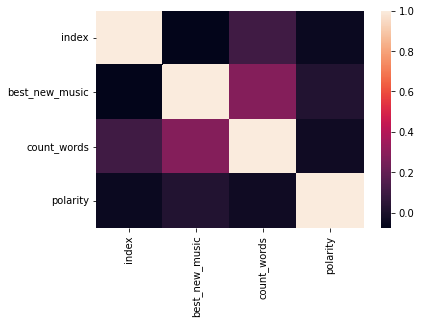

In [128]:
import seaborn as sns

sns.heatmap(final.corr())

> Created a heatmap to check if polarity and count_words are highly co-related, then they can be multiplied with each other to get a new column, but that does not seem to be the case.

In [130]:
# our data mostly has categorical variables
# to check if the two variables are similar, and can be multiplied
# or only one of them can be used

from scipy.stats import chi2_contingency
from scipy.stats import chi2
table= pd.crosstab(final['author'],
                   final['author_type'],
                   margins= True, margins_name="Total")
stat, p, dof, expected= chi2_contingency(table)
print('dof=%d' %dof)
print(expected)

# interpret p-value
alpha= 0.05
print('significance= %.3f, p=%.3f' % (alpha,p))
if p<= alpha:
  print('Dependent (reject H0)')
else:
  print('Independent (fail to reject H0)')

dof=3690
[[1.07530364e-01 2.28502024e-01 6.72064777e-02 ... 2.70842105e+00
  3.22591093e-01 8.30000000e+01]
 [3.88663968e-03 8.25910931e-03 2.42914980e-03 ... 9.78947368e-02
  1.16599190e-02 3.00000000e+00]
 [1.29554656e-03 2.75303644e-03 8.09716599e-04 ... 3.26315789e-02
  3.88663968e-03 1.00000000e+00]
 ...
 [1.74898785e-01 3.71659919e-01 1.09311741e-01 ... 4.40526316e+00
  5.24696356e-01 1.35000000e+02]
 [8.16194332e-02 1.73441296e-01 5.10121457e-02 ... 2.05578947e+00
  2.44858300e-01 6.30000000e+01]
 [1.60000000e+01 3.40000000e+01 1.00000000e+01 ... 4.03000000e+02
  4.80000000e+01 1.23500000e+04]]
significance= 0.050, p=0.000
Dependent (reject H0)


> Since, the 2 variables are dependent, we can either use one of them, or multiply the two and use them together. This is so because both columns contain essentially the same information.

> If they were not dependent, we would at least have to start by using both the variables, and then decide based on model results if either or both of the variables should be used or not based on model results.

> Another way to look at feature engineering can be to utilize our expert knowledge about the domain and industry to come up with new features. This will be more likely to happen in real-world business scenarios.

## Data Visualization

##### Using the results from your regression and data analysis create a visualization that tells a story about the data. Feel free to take personal liberties with this and be as creative as you like.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


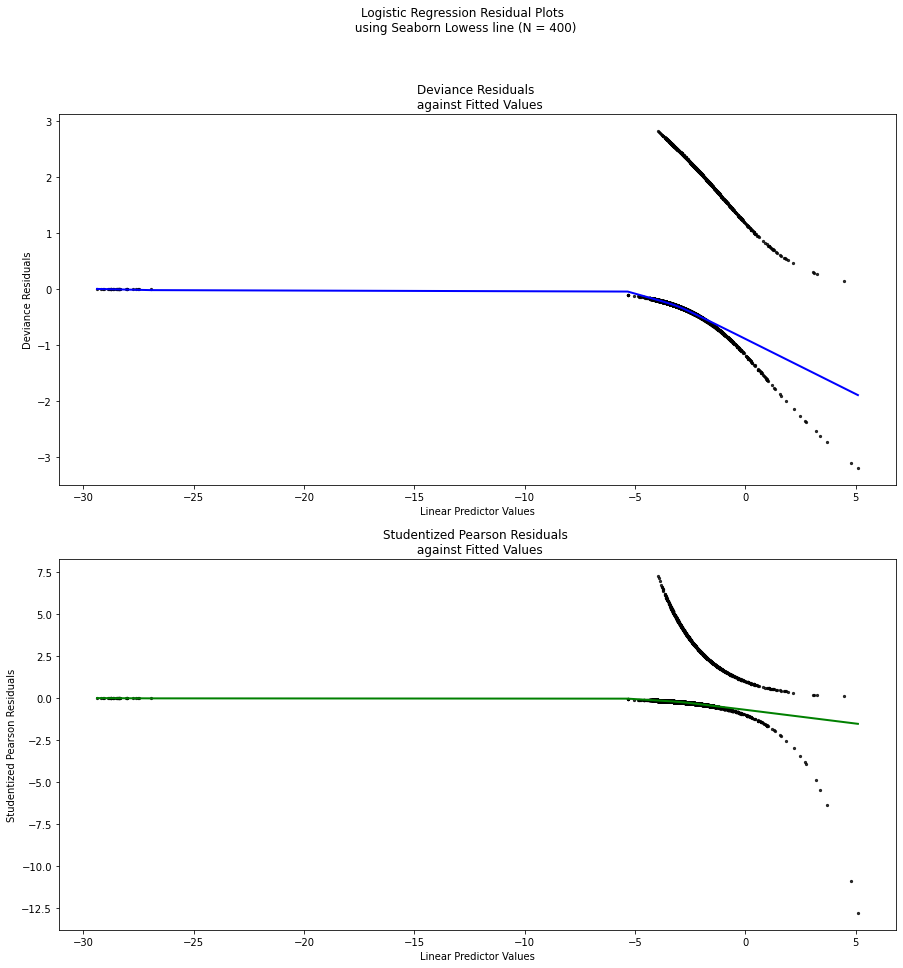

In [122]:
import seaborn as sns

## Plotting multiple plots same figure
fig, (axL, axR) = plt.subplots(2, figsize=(15, 15))
plt.suptitle("Logistic Regression Residual Plots \n using Seaborn Lowess line (N = 400)")


# Deviance Residuals
sns.regplot(model.fittedvalues, model.resid_dev, ax= axL,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"b", "alpha":1, "lw":2}, lowess=True)

axL.set_title("Deviance Residuals \n against Fitted Values")
axL.set_xlabel("Linear Predictor Values")
axL.set_ylabel("Deviance Residuals")

# Studentized Pearson Residuals
sns.regplot(model.fittedvalues, model.resid_pearson, ax= axR,
            color="black", scatter_kws={"s": 5},
            line_kws={"color":"g", "alpha":1, "lw":2}, lowess=True)

axR.set_title("Studentized Pearson Residuals \n against Fitted Values")
axR.set_xlabel("Linear Predictor Values")
axR.set_ylabel("Studentized Pearson Residuals")

plt.show()